#### Setup

"birmingham_block_7_subsampled_test.ply" and "birmingham_block_7_subsampled_train.ply" are on disk https://drive.google.com/drive/folders/1NcyotKFRzjLah6urkxNzLXmX8rMpkjkZ

"birmingham_block_6.ply" you need to download it here https://drive.google.com/drive/folders/1xd6oc0yJFQ74r54zVJCTGypohvv7ajXG

btw I subsample points in CloudCompare with minimal distance of 0.2

In [1]:
import pandas as pd
from pyntcloud import PyntCloud
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import seaborn as sns 
import numpy as np
import pyvista as pv
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics import Precision, Accuracy, Recall

In [2]:
pt = PyntCloud.from_file('../data/birmingham_blocks/birmingham_block_6.ply')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
pt.points

,x,y,z,red,green,blue,class
0,437.12500,1255.12500,9.480003,118,155,96,1
1,435.84375,1254.18750,9.349998,88,116,76,1
2,447.34375,1261.78125,10.750000,48,83,33,1
3,447.03125,1260.50000,11.950005,118,155,58,1
4,443.56250,1257.87500,10.480003,88,122,43,1
...,...,...,...,...,...,...,...
17058908,579.68750,1234.12500,16.610001,191,180,159,2
17058909,582.06250,1234.96875,16.770004,190,192,172,2
17058910,580.62500,1234.62500,16.900002,208,203,179,2
17058911,578.68750,1234.06250,16.880005,104,98,86,2


#### Points normalization

*Min-max*: this would require outliers removal but leaves the original distribution in the same shape

*Z-score*: the output range is not limited 

I think that *min-max* is more appropriate 

In [4]:
coords = pt.points[['x', 'y', 'z']].values

"""x = (coords[:, 0] - np.mean(coords[:, 0])) / np.std(coords[:, 0])
y = (coords[:, 1] - np.mean(coords[:, 1])) / np.std(coords[:, 1])
z = (coords[:, 2] - np.mean(coords[:, 2])) / np.std(coords[:, 2])
"""

x = (coords[:, 0] - np.min(coords[:, 0])) / (np.max(coords[:, 0]) - np.min(coords[:, 0]))
y = (coords[:, 1] - np.min(coords[:, 1])) / (np.max(coords[:, 1]) - np.min(coords[:, 1]))
z = (coords[:, 2] - np.min(coords[:, 2])) / (np.max(coords[:, 2]) - np.min(coords[:, 2]))

normalized_cloud = np.column_stack([x, y, z])

In [15]:
point_cloud = pv.PolyData(normalized_cloud)
point_cloud.cell_data['colors'] = pt.points[['red', 'green', 'blue']].values

In [19]:
# Viz works better outside of notebook environment
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(point_cloud, point_size=3, render_points_as_spheres=True,
                 scalars='colors', lighting=False, rgb=True, preference='cell')
plotter.show()

NameError: name 'point_cloud' is not defined

In [5]:
classes_count = pd.DataFrame(pt.points['class']).value_counts().reset_index().set_index('class')

In [6]:
classes_count

,count
class,
2,5450877
1,5238617
0,3648426
7,1349248
9,327182
3,295100
8,274296
5,255924
10,153411


In [19]:
classes_df = pd.DataFrame.from_dict({'class': np.arange(13), 'name': ['ground', 'vegetation', 'building', 'wall', 'bridge', 
    'parking', 'rail', 'traffic road', 'street furniture', 'car', 'footpath', 'bike', 'water']}).set_index('class')
classes_df

,name
class,
0,ground
1,vegetation
2,building
3,wall
4,bridge
5,parking
6,rail
7,traffic road
8,street furniture


In [20]:
counts = classes_df.join(classes_count).fillna(0)

Observations:
- some classes are not present at all
- classes are imbalanced

Idea: 
- Examine different clouds and compare counts of classes between them 

<Axes: xlabel='count', ylabel='name'>

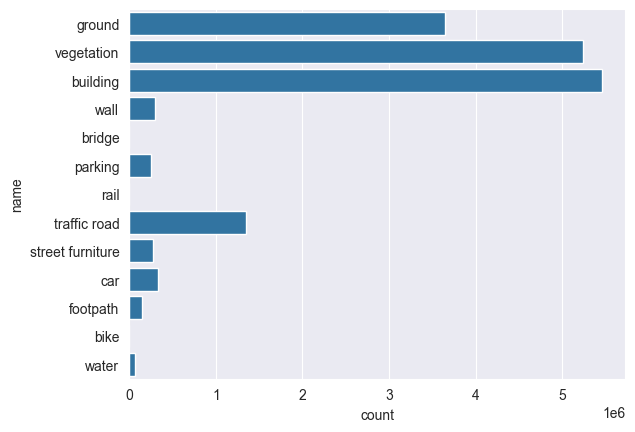

In [21]:
sns.barplot(counts, y='name', x='count')

#### Point Net Implementation

In [14]:
class Tnet(nn.Module):
    
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       
   def forward(self, input):
        # input.shape == (bs, n, 3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten()(pool) # (bs, 1024)
        xb = F.relu(self.bn4(self.fc1(flat))) # (bs, 512)
        xb = F.relu(self.bn5(self.fc2(xb))) # (bs, 256)
        
        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs, 1, 1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1, self.k, self.k) + init
        return matrix
      
      
t_net = Tnet(k=3)
matrix_3x3 = t_net.forward(torch.randn(10, 1024, 3).transpose(2, 1))
matrix_3x3.shape

torch.Size([10, 3, 3])

In [15]:
class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2) # why transpose?

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb) # global feature (bs, 1024, 1?)
        output = nn.Flatten()(xb)
        return output, matrix3x3, matrix64x64
   
transform_net = Transform()
out, m3x3, m64x64 = transform_net.forward(torch.randn(10, 1024, 3).transpose(2, 1))
print(out.shape)

torch.Size([10, 1024])


In [16]:
mat = torch.randn(10, 1024, 3)
print(mat[0, 0])
pooling_result = nn.MaxPool1d(3)(mat)
print(pooling_result.shape)

tensor([-0.2934,  1.4479, -0.4822])
torch.Size([10, 1024, 1])


In [17]:
nn.Flatten()(pooling_result).shape

torch.Size([10, 1024])

In [18]:
class PointNetClassifier(pl.LightningModule):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return output, matrix3x3, matrix64x64
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        loss = F.cross_entropy(predictions, y)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        loss = F.cross_entropy(predictions, y)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {'val_loss': loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        predicted_labels = torch.argmax(predictions, dim=-1)
        return predicted_labels

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

#### Steps

1. Dataset that reads a points cloud(s)
2. Transformations: normalization, rotation?, ... 
3. Subsampling point cloud to create 'batch-cloud' 

In [19]:
point_net = PointNetClassifier()
logits, m3x3, m64x64 = point_net.forward(torch.randn(10, 1024, 3).transpose(2, 1))
logits.shape

torch.Size([10, 10])

In [20]:
def min_max_standardize(coords):
    x = (coords.loc[:, 'x'] - np.min(coords.loc[:, 'x'])) / (np.max(coords.loc[:, 'x']) - np.min(coords.loc[:, 'x']))
    y = (coords.loc[:, 'y'] - np.min(coords.loc[:, 'y'])) / (np.max(coords.loc[:, 'y']) - np.min(coords.loc[:, 'y']))
    z = (coords.loc[:, 'z'] - np.min(coords.loc[:, 'z'])) / (np.max(coords.loc[:, 'z']) - np.min(coords.loc[:, 'z']))
    
    return x, y, z

In [21]:
class PointSampler: # Smarter way to sample point cloud?
    
    def __init__(self, subsample_size):
        self.subsample_size = subsample_size
    
    def __call__(self, point_cloud):
        indices = np.random.choice(point_cloud.index.values, size=self.subsample_size, replace=False)
        sampled_points = point_cloud.loc[indices]
        return sampled_points
    

class MockPointSampler:
    
    def __call__(self, point_cloud):
        return point_cloud

In [22]:
# this is broken a bit
class PointCloudClassificationDataset(Dataset):
    
    def __init__(self, point_cloud_path, subsample_size, point_sampler, classes_df):
        self.subsample_size = subsample_size
        self.point_sampler = point_sampler
        self.pt = PyntCloud.from_file(point_cloud_path)
        x, y, z = min_max_standardize(self.pt.points[['x', 'y', 'z']])
        
        self.pt.points['x_norm'] = x 
        self.pt.points['y_norm'] = y
        self.pt.points['z_norm'] = z

        # select classes with non-zero count
        counts = classes_df.join(classes_count).fillna(0)
        self.classes = counts[counts['count'] > 0].reset_index(drop=True)
        
    def __len__(self):
        return self.subsample_size
    
    def __getitem__(self, idx):
        chosen_class = idx % len(self.classes)
        sampled_cloud = self.point_sampler(self.pt.points.loc[self.pt.points['class'] == chosen_class, 
                ['x_norm', 'y_norm', 'z_norm']])
        sampled_points = torch.tensor(sampled_cloud[['x_norm', 'y_norm', 'z_norm']].values, device=device)
        label = torch.scalar_tensor(chosen_class, device=device, dtype=torch.long)
        return sampled_points.T, label 

### Segmentation network

In [23]:
class Transform_2(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input, 1, 2), matrix3x3).transpose(1, 2) 

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb, 1, 2), matrix64x64).transpose(1, 2) 
        
        # compute global features
        global_xb = F.relu(self.bn2(self.conv2(xb)))
        global_xb = self.bn3(self.conv3(global_xb))
        global_xb = nn.MaxPool1d(global_xb.size(-1))(global_xb).transpose(2, 1) # global feature (bs, 1024, 1?)
        
        return xb, global_xb, matrix3x3, matrix64x64
   
transform_net_2 = Transform_2()
x, g_x, _, _ = transform_net_2.forward(torch.randn(10, 1024, 3).transpose(2, 1))
x.shape, g_x.shape

(torch.Size([10, 64, 1024]), torch.Size([10, 1, 1024]))

In [24]:
g = torch.repeat_interleave(g_x, 1024, dim=1)
g.shape

torch.Size([10, 1024, 1024])

In [25]:
x.transpose(1, 2).shape

torch.Size([10, 1024, 64])

In [26]:
# this is how global and local features are concatenated
torch.concat([x.transpose(1, 2), g], dim=2).shape

torch.Size([10, 1024, 1088])

In [50]:
def segmentation_loss(outputs, labels, m3x3, m64x64, alpha=0.001):
    '''
    Cross entropy loss plus regularization for transformation matrices
    '''
    criterion = torch.nn.CrossEntropyLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)
    

In [57]:
class PointNetSegmentor(pl.LightningModule):
    def __init__(self, classes = 10):
        super().__init__()
        self.precision = Precision(task="multiclass", average='macro', num_classes=classes)
        self.recall = Recall(task="multiclass", average='macro', num_classes=classes)
        self.accuracy = Accuracy(task="multiclass", num_classes=classes)
        self.transform = Transform_2()
        self.conv1 = nn.Conv1d(1088, 512, 1)
        self.conv2 = nn.Conv1d(512, 256, 1)
        self.conv3 = nn.Conv1d(256, 128, 1)
        self.conv4 = nn.Conv1d(128, classes, 1)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(classes)
        
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input):
        xb, g_x, matrix3x3, matrix64x64 = self.transform(input)  # xb is of shape (bs, 63, cld_s)
        cld_s = xb.shape[-1]
        
        g = torch.repeat_interleave(g_x, cld_s, dim=1)
        x = torch.concat([xb.transpose(1, 2), g], dim=2).transpose(1, 2) # concatenate global and per-point features
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.dropout(self.bn4(self.conv4(x))))
        
        return x, matrix3x3, matrix64x64
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        loss = segmentation_loss(predictions, y, matrix3x3, matrix64x64)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('train_accuracy', self.accuracy(predictions, y), prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('train_precision', self.precision(predictions, y), prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('train_recall', self.recall(predictions, y), prog_bar=True, sync_dist=True, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions, matrix3x3, matrix64x64 = self(x)
        loss = segmentation_loss(predictions, y, matrix3x3, matrix64x64)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('val_accuracy', self.accuracy(predictions, y), prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('val_precision', self.precision(predictions, y), prog_bar=True, sync_dist=True, on_epoch=True)
        self.log('val_recall', self.recall(predictions, y), prog_bar=True, sync_dist=True, on_epoch=True)
        return {'val_loss': loss}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        predictions, _, _ = self(x)
        return torch.argmax(predictions, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [52]:
segmentor = PointNetSegmentor(6)
logits, m3x3, m64x64 = segmentor.forward(torch.randn(10, 1024, 3).transpose(2, 1))

In [53]:
logits.shape # (bs, # of classes, cld_s)

torch.Size([10, 6, 1024])

In [30]:
torch.argmax(logits, dim=1).shape

torch.Size([10, 1024])

In [31]:
F.cross_entropy(logits, torch.randint(low=0, high=6, size=(10, 1024)))

tensor(2.0245, grad_fn=<NllLoss2DBackward0>)

In [54]:
segmentation_loss(logits, torch.randint(low=0, high=6, size=(10, 1024)), m3x3, m64x64)

tensor(2.0964, grad_fn=<AddBackward0>)

#### Dataset Challenges
- how should we preprocess original clouds? ex. subsampling, cutting ...
- what method to use to normalize point cloud?
- how to subsample point clouds for batches?
- how to handle multiple point clouds that can be used?
- how to handle class imbalance? 

In [58]:
class PointCloudSegmentationDataset(Dataset):
    
    def __init__(self, point_cloud_path, subsample_size=None, point_sampler=None, ds_size=None):
        self.point_sampler = point_sampler if point_sampler else MockPointSampler()
        self.pt = PyntCloud.from_file(point_cloud_path)
        self.ds_size = ds_size
        self.subsample_size = subsample_size if subsample_size else len(self.pt.points)
        x, y, z = min_max_standardize(self.pt.points[['x', 'y', 'z']])
        
        self.pt.points['x_norm'] = x 
        self.pt.points['y_norm'] = y
        self.pt.points['z_norm'] = z 
        
        self.label = 'class' if 'class' in self.pt.points.columns else 'scalar_class'
        
    def __len__(self):
        # How to set the number of batches?
        return len(self.pt.points) // self.subsample_size if self.ds_size is None else self.ds_size
    
    def __getitem__(self, idx):
        # For now, a point cloud is sampled each time this function is called (it doesn't depend on idx)
        sampled_cloud = self.point_sampler(self.pt.points[['x_norm', 'y_norm', 'z_norm', self.label]])
        sampled_points = torch.tensor(sampled_cloud[['x_norm', 'y_norm', 'z_norm']].values, device=device)
        labels = torch.tensor(sampled_cloud[[self.label]].values, device=device, dtype=torch.long).flatten()
        return sampled_points.T, labels
    

In [59]:
subsample_size = 1024 # as in original paper but ofc can be different
batch_size = 16

training_dataset = PointCloudSegmentationDataset('../data/birmingham_blocks/birmingham_block_7_subsampled.ply', 
                                     subsample_size=subsample_size, point_sampler=PointSampler(subsample_size=subsample_size))
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = PointCloudSegmentationDataset('../data/birmingham_blocks/birmingham_block_6_subsampled_test.ply', 
                                     subsample_size=subsample_size, point_sampler=PointSampler(subsample_size=subsample_size))
val_loader = DataLoader(validation_dataset, batch_size=batch_size)

model = PointNetSegmentor(classes=len(classes_df))


Each batch is a sampled point cloud

This is minimal training set up, we lack validation and some regularizations

In [61]:
experiment_name = "banana_2"
checkpoint_dir = Path(f"../models/{experiment_name}")
logger = TensorBoardLogger(save_dir=f"../models/{experiment_name}/tlogs", name=experiment_name)

max_epochs = 50

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir / 'best_results', filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
# early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)

trainer = pl.Trainer(max_epochs=max_epochs, fast_dev_run=False, 
                     default_root_dir=checkpoint_dir, callbacks=[checkpoint_callback], logger=logger)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type                | Params | Mode 
-----------------------------------------------------------
0  | precision | MulticlassPrecision | 0      | train
1  | recall    | MulticlassRecall    | 0      | train
2  | accuracy  | MulticlassAccuracy  | 0      | train
3  | transform | Transform_2         | 2.8 M  | train
4  | conv1     | Conv1d              | 557 K  | train
5  | conv2     | Conv1d              | 131 K  | train
6  | conv3     | Conv1d              | 32.9 K | train
7  | conv4     | Conv1d              | 1.7 K  | train
8  | bn1       | BatchNorm1d         | 1.0 K  | train
9  | bn2       | BatchNorm1d         | 512    | train
10 | bn3       | BatchNorm1d         | 256    | train
11 | bn4       | BatchNorm1d         | 26     | train
12 | dropout   | Dropout             | 0      | train
-------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\julia\anaconda3\envs\geo\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\julia\anaconda3\envs\geo\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\julia\anaconda3\envs\geo\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

In [2]:
%load_ext tensorboard

In [48]:
testing_dataset = PointCloudSegmentationDataset('../data/birmingham_blocks/birmingham_block_7_subsampled_test.ply')
test_loader = DataLoader(testing_dataset)
preds = trainer.predict(model, test_loader)[0]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\julia\anaconda3\envs\geo\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [49]:
preds

tensor([[5, 5, 5,  ..., 5, 5, 5]])

In [50]:
predictions = preds[0].numpy()

In [51]:
predictions

array([5, 5, 5, ..., 5, 5, 5], dtype=int64)

In [52]:
for batch in test_loader:
    _, labels = batch

In [53]:
labels = labels.cpu().numpy()[0]